In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

from mhar import walk
import torch

import sklearn.gaussian_process as gp

from skopt import gp_minimize

import time

from UTA import UTA

np.random.seed(42)

In [2]:
df = pd.DataFrame(np.random.randn(50, 6), columns=['a', 'b', 'c', 'd', 'e', 'f'])
df

,a,b,c,d,e,f
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137
1,1.579213,0.767435,-0.469474,0.542560,-0.463418,-0.465730
2,0.241962,-1.913280,-1.724918,-0.562288,-1.012831,0.314247
3,-0.908024,-1.412304,1.465649,-0.225776,0.067528,-1.424748
4,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694
5,-0.601707,1.852278,-0.013497,-1.057711,0.822545,-1.220844
6,0.208864,-1.959670,-1.328186,0.196861,0.738467,0.171368
7,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122
8,0.343618,-1.763040,0.324084,-0.385082,-0.676922,0.611676
9,1.031000,0.931280,-0.839218,-0.309212,0.331263,0.975545


In [3]:
model = UTA(df.copy(), n_points=3)

In [4]:
df.iloc[[49, 2]]

,a,b,c,d,e,f
49,0.357015,-0.69291,0.899600,0.307300,0.812862,0.629629
2,0.241962,-1.91328,-1.724918,-0.562288,-1.012831,0.314247


Element 49 is better on all criteria than element 2, thus scoring them would not improve model stability. The worse correlation between rankings returned by different models based on this comparison is close to -1

In [5]:
model.scorePair(df.iloc[49].values, df.iloc[2].values)

domination


-9

In [6]:
model.better

[]

In [7]:
df.iloc[[17, 49]]

,a,b,c,d,e,f
17,-0.342715,-0.802277,-0.161286,0.404051,1.886186,0.174578
49,0.357015,-0.692910,0.899600,0.307300,0.812862,0.629629


Element 49 is better than 17 on 4 out of 6 criteria and worse on the remaining 2. Scoring these two models would enrich our model with some preference information; however, it can still be better.

In [8]:
model.scorePair(df.iloc[17].values, df.iloc[49].values)

0.11529411764705881

In [9]:
df.iloc[[13, 6]]

,a,b,c,d,e,f
13,0.091761,-1.987569,-0.219672,0.357113,1.477894,-0.518270
6,0.208864,-1.959670,-1.328186,0.196861,0.738467,0.171368


Element 13 is better than element 6 on 3 criteria and worse on 3 remaining ones. Knowledge about the relation between these two alternatives can significantly improve model stability

In [10]:
model.scorePair(df.iloc[13].values, df.iloc[6].values)

0.18857142857142856

We provide preference information $e_6 \succ e_{13}$ and then present ranking based on this one comparison

In [11]:
model.addBetter(df.iloc[6].values, df.iloc[13].values)
df["score"] = model.getRanking()
df.sort_values("score", ascending=False)

,a,b,c,d,e,f,score
18,0.257550,-0.074446,-1.918771,-0.026514,0.060230,2.463242,1.000000
10,-0.479174,-0.185659,-1.106335,-1.196207,0.812526,1.356240,1.000000
20,0.791032,-0.909387,1.402794,-1.401851,0.586857,2.190456,1.000000
33,0.058209,-1.142970,0.357787,0.560785,1.083051,1.053802,1.000000
34,-1.377669,-0.937825,0.515035,0.513786,0.515048,3.852731,1.000000
11,-0.072010,1.003533,0.361636,-0.645120,0.361396,1.538037,1.000000
29,0.276691,0.827183,0.013002,1.453534,-0.264657,2.720169,1.000000
7,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,1.000000
27,1.158596,-0.820682,0.963376,0.412781,0.822060,1.896793,1.000000
9,1.031000,0.931280,-0.839218,-0.309212,0.331263,0.975545,0.993990


[-1.377669367957091, -1.377669367957091, 0.3831373606841173, 2.1439440893253257, 2.1439440893253257]
[0.0, 0.0, 0.0, 0.0, 0.0]
[-1.37766937  0.38313736  2.14394409]
[0. 0. 0.]


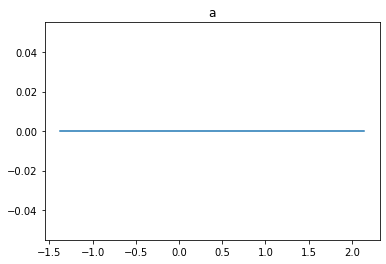

[-1.9875689146008928, -1.9875689146008928, -0.06764536504597762, 1.8522781845089378, 1.8522781845089378]
[0.0, 0.0, 0.0, 0.0, 0.0]
[-1.98756891 -0.06764537  1.85227818]
[0. 0. 0.]


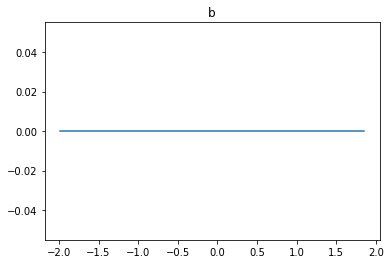

[-2.6197451040897444, -2.6197451040897444, -0.24335586471673887, 2.1330333746562666, 2.1330333746562666]
[0.0, 0.0, 0.0, 0.0, 0.0]
[-2.6197451  -0.24335586  2.13303337]
[0. 0. 0.]


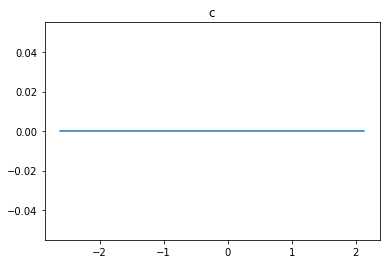

[-1.9520877995225019, -1.9520877995225019, -0.20107669725248134, 1.5499344050175394, 1.5499344050175394]
[0.0, 0.0, 0.0, 0.0, 0.0]
[-1.9520878  -0.2010767   1.54993441]
[0. 0. 0.]


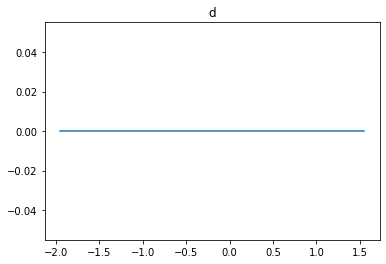

[-3.2412673400690726, -3.2412673400690726, -0.46330438669778173, 2.3146585666735087, 2.3146585666735087]
[0.0, 0.0, 0.0, 0.0, 0.0]
[-3.24126734 -0.46330439  2.31465857]
[0. 0. 0.]


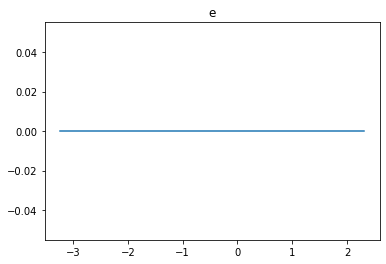

[-1.867265192591748, -1.867265192591748, 0.9927331490314866, 3.852731490654721, 3.852731490654721]
[0.0, 0.0, 1.0, 1.0, 1.0]
[-1.86726519  0.99273315  3.85273149]
[0. 1. 1.]


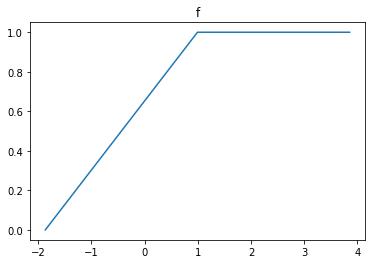

In [12]:
model.plotUtilityFunctions()

In [13]:
df.iloc[[17, 49]]

,a,b,c,d,e,f,score
17,-0.342715,-0.802277,-0.161286,0.404051,1.886186,0.174578,0.713932
49,0.357015,-0.692910,0.899600,0.307300,0.812862,0.629629,0.873040


Now the comparison between 17 and 49 is a nice addition to the model since it provides information that was not available in the first comparison.

In [14]:
model.scorePair(df.iloc[17,:6].values, df.iloc[49,:6].values)

0.21507803121248498

We can also create fictive alternatives to obtain preference information. With this approach we can create a stable model in smaller number of iterations.

To find the best pair to compare gaussian process is used

In [15]:
f = lambda x : -model.scorePair(x[:6], x[6:])
start = time.time()
res = gp_minimize(f,                  # the function to minimize
                  [(-1.0, 1.0) for _ in range(12)],      # the bounds on each dimension of x
                  n_calls=50,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  random_state=0)   # the random seed
time.time() - start

domination
domination
domination


105.08945322036743

In [16]:
res.fun, res.x[:6], res.x[6:]

(-0.2629051620648259,
 [-0.7083379408892525,
  0.3438047680702756,
  -0.599750620675056,
  0.3899380349456787,
  0.6795413182293675,
  1.0],
 [0.5213225443410037,
  0.9453586075717773,
  -0.758010657438912,
  -0.205759772954468,
  0.856145074069756,
  -0.7951319009574702])

In [17]:
model.scorePair(res.x[6:], res.x[:6])

0.2629051620648259

To compare performance we will find the best pair to compare using random search with fictive alternatives and random search using real alternatives

In [17]:
start = time.time()
score = []
pairs = []
for _ in range(300):
    i,j = np.random.choice(np.arange(len(df)), 2)
    score.append(model.scorePair(df.iloc[i,:6].values, df.iloc[j,:6].values))
    pairs.append([i,j])
print(time.time() - start)
print(max(score))


Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non 

Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non 

/home/miebs/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
/home/miebs/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
/home/miebs/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider als

Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non 

In [18]:
start = time.time()
score = []
pairs = []
for _ in range(300):
    i,j = np.random.randn(6), np.random.randn(6)
    score.append(model.scorePair(i, j))
    pairs.append([i,j])
print(time.time() - start)
print(max(score))

Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non 

Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)


/home/miebs/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
/home/miebs/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
/home/miebs/.local/lib/python3.6/site-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.64718e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non 

Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non 

We provide second comparison of fictive alternatives and present ranking based on the updated model

In [18]:
model.addBetter(res.x[6:], res.x[:6])
df["score"] = model.getRanking()
df.sort_values("score", ascending=False)

,a,b,c,d,e,f,score
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.000000
23,0.813517,-1.230864,0.227460,1.307143,-1.607483,0.184634,1.000000
29,0.276691,0.827183,0.013002,1.453534,-0.264657,2.720169,1.000000
37,0.686260,-1.612716,-0.471932,1.088951,0.064280,-1.077745,1.000000
26,1.865775,0.473833,-1.191303,0.656554,-0.974682,0.787085,0.732888
35,0.570891,1.135566,0.954002,0.651391,-0.315269,0.758969,0.728873
1,1.579213,0.767435,-0.469474,0.542560,-0.463418,-0.465730,0.644230
30,0.625667,-0.857158,-1.070892,0.482472,-0.223463,0.714000,0.597498
27,1.158596,-0.820682,0.963376,0.412781,0.822060,1.896793,0.543296
32,0.214094,-1.245739,0.173181,0.385317,-0.883857,0.153725,0.521936


[-1.377669367957091, 0.0917607765355023, 0.2088635950047554, 0.9965706656190252, 1.0, 2.1439440893253257]
[0.0, 0.0, 0.5, 0.5, 0.5, 0.5]
[0.09176078 0.2088636  0.99657067 1.        ]
[0.  0.5 0.5 0.5]


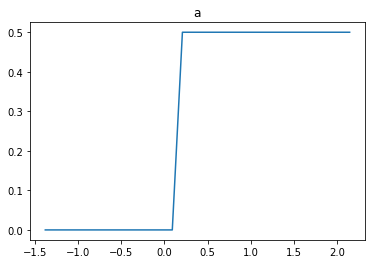

[-1.9875689146008928, -1.9875689146008928, -1.9596701238797756, -1.0, 1.8522781845089378]
[0.0, 0.0, 0.0, 0.0, 0.0]
[-1.98756891 -1.95967012 -1.        ]
[0. 0. 0.]


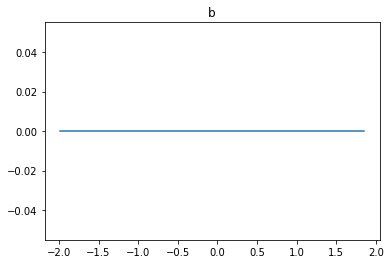

[-2.6197451040897444, -1.3281860488984305, -1.0, -0.21967188783751193, 1.0, 2.1330333746562666]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-1.32818605 -1.         -0.21967189  1.        ]
[0. 0. 0. 0.]


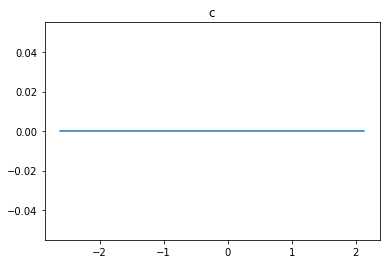

[-1.9520877995225019, -0.3290293166088034, 0.19686123586912352, 0.3571125715117464, 1.0, 1.5499344050175394]
[0.0, 0.0, 0.0, 0.0, 0.5, 0.5]
[-0.32902932  0.19686124  0.35711257  1.        ]
[0.  0.  0.  0.5]


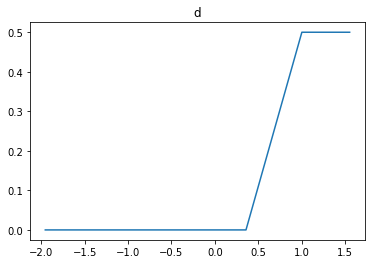

[-3.2412673400690726, -1.0, -0.952160802111406, 0.7384665799954104, 1.477894044741516, 2.3146585666735087]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-1.         -0.9521608   0.73846658  1.47789404]
[0. 0. 0. 0.]


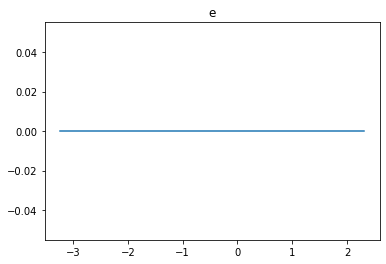

[-1.867265192591748, -0.5182702182736474, -0.007938972237444109, 0.1713682811899705, 1.0, 3.852731490654721]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-0.51827022 -0.00793897  0.17136828  1.        ]
[0. 0. 0. 0.]


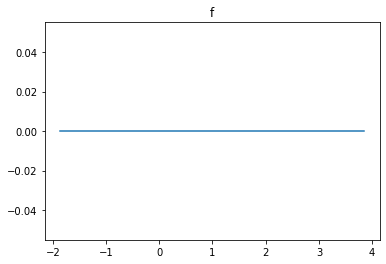

In [19]:
model.plotUtilityFunctions()

In [21]:
f = lambda x : -model.scorePair(x[:6], x[6:])
start = time.time()
res = gp_minimize(f,                  # the function to minimize
                  [(-1.0, 1.0) for _ in range(12)],      # the bounds on each dimension of x
                  n_calls=50,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  random_state=0)   # the random seed
time.time() - start

Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non zero error:  tensor(0.)
Max non 

117.44114136695862

In [22]:
res.fun, res.x[:6], res.x[6:]

(-0.9710924369747899,
 [1.0,
  -1.0,
  0.5331454306610517,
  -0.7433337929729931,
  -0.4148386804528297,
  0.6850761966629622],
 [-1.0,
  1.0,
  -0.5408471631307252,
  -0.8520567640395524,
  -1.0,
  -0.948767379833774])

In [23]:
model.addBetter(res.x[6:], res.x[:6])
df["score"] = model.getRanking()
df.sort_values("score", ascending=False)

,a,b,c,d,e,f,score
29,0.276691,0.827183,0.013002,1.453534,-0.264657,2.720169,0.982718
22,-1.062304,0.473592,-0.919424,1.549934,-0.783253,-0.322062,0.947359
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,0.886174
12,-0.035826,1.564644,-2.619745,0.821903,0.087047,-0.299007,0.810131
23,0.813517,-1.230864,0.227460,1.307143,-1.607483,0.184634,0.800000
37,0.686260,-1.612716,-0.471932,1.088951,0.064280,-1.077745,0.800000
40,-0.792521,-0.114736,0.504987,0.865755,-1.200296,-0.334501,0.745408
35,0.570891,1.135566,0.954002,0.651391,-0.315269,0.758969,0.628349
26,1.865775,0.473833,-1.191303,0.656554,-0.974682,0.787085,0.581236
1,1.579213,0.767435,-0.469474,0.542560,-0.463418,-0.465730,0.489068


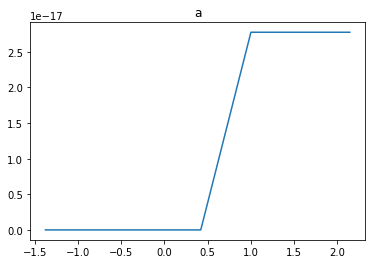

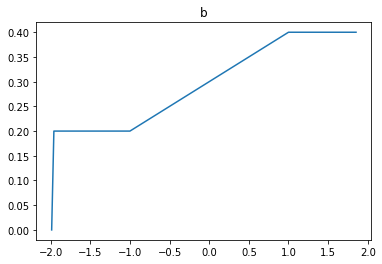

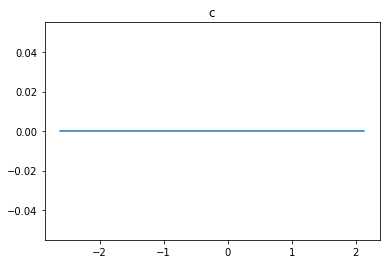

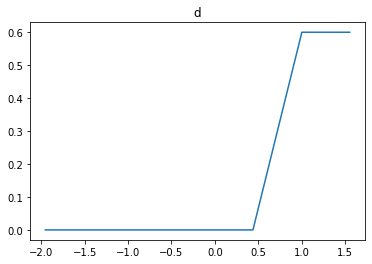

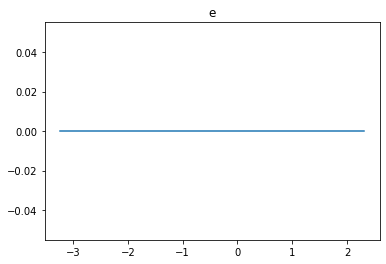

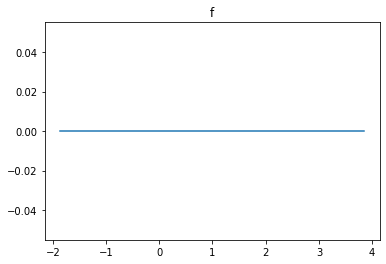

In [24]:
model.plotUtilityFunctions()